In [1]:
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from catboost import CatBoostClassifier
import shap
from utils import clean
import pandas as pd

### Loading in the data with the desired features

Data (along with labels) can be found here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910/DVN/GDF6Z0

In [2]:
cols = ['gender', 'birthyr', 'educ', 'race', 'countyfips', 'pew_religimp', 'newsint', 'CC16_351I', 'CC16_302', 'CC16_331_7', 'CC16_330d', 'CC16_332a', 'CC16_351K', 'CC16_335', 'CC16_364c']
df = pd.read_csv('data/CCES16_Common_OUTPUT_Feb2018_VV.tab', sep='\t', header=0, usecols=cols)[cols]
df = clean(df)

### Evaluating the features (questions) with SHAP
#### Please use the "CCES Guide 2016.pdf" in the prior link for better understanding

In [3]:
data = df.drop('CC16_364c', axis=1)
classifier = CatBoostClassifier().load_model('catboost_classifier')
shap.initjs()
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(data)

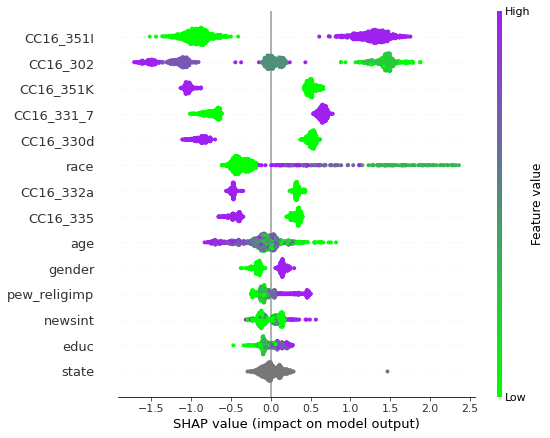

In [4]:
shap.summary_plot(shap_values[1000:2000], data[1000:2000], cmap=LinearSegmentedColormap.from_list("", ["#00FF00", "#A020F0"]))

Here we can see the relative feature importance in the predictive model in descending order. Note the color bar scale. If the response to a particular prompt is high (within the scale of options), then the color is purple (and low for green). For an example of reading this, let's look at the case of 'CC16_351l', or 'Would you repeal the Affordable Care Act?' with 'Yes' as 1, and 'No' as 2. When the response to this question is 'Yes', or 1, there is a large cluster of green points that correspond to a negative SHAP value - meaning that this response will signal to the model that the responder is likely a Trump voter.<br>For the relative feature importance, this follows from a combination of the width and extrema densities  of the SHAP value distributions per feature. The wider the width, the larger the effect on the prediction a feature likely has.<br> Using this, we see that the top 5 most important prompts for predicting presidental voting in the 2016 election were: repealing the Affordable Care Act, direction of the national economy, minimum wage increase, and deportation of illegal immigrants.

In [5]:
# It is best to run this notebook yourself so you can use this interactive plot to explore the results at will.
shap.force_plot(explainer.expected_value, shap_values[:1000], data[:1000], plot_cmap=["#0000FF","#FF0000"])

When keeping the y variable as f(x), we can see the effect that each feature or prompt has on the predicted value, and therefore class, which in this case is presidental candidate. First thing to note is that the plots are solid polygons, where the actual domain for each feature is discrete (so some smoothing/interpolation is being done, but the general picture still applies). Secondly, recall that Trump's label was 1, and Clinton's was 2.<br>Now let's look at an example, 'CC16_351l', or 'Would you repeal the Affordable Care Act?' with 'Yes' as 1, and 'No' as 2.<br>Looking at the plot, we see that there is more red on the left, and the y value of all of these points is below 0, meaning that when answering 'Yes' to this question, it results in the model moving the prediction 'down' towards 1. On the other hand, when answering with 'No', a positive effect on the prediction is seen. This is good as it checks out with known voting trends and beliefs. I also changed the color mapping to help further indicate that a positive f(x) reflects a movement in the prediction towards Clinton, a Democrat (Blue), while the opposite is true for Trump, a Republican (Red).<br>For a slightly more detailed analysis, one can change the y axis from f(x) to another feature in order to see how the x variable selected at the top of the plot effects the y variable.